In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from model import ode_y, ode_y_jump_approach_one_boundary, uncertainty_decomposition
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

In [3]:
# Simulate capital process
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

## SCC and Uncertainty

In [15]:
ξ_w = .3
ξ_p = 5.
ξ_a = 100000.

ϵ = 5.
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

σ_y = 1.2*np.mean(θ)
y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_step = .02
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

# Uncertainty decomposition
n_temp = 16
n_carb = 9
θ_reshape = θ.reshape(n_temp, n_carb)
θ_temp = np.mean(θ_reshape, axis=1)
θ_carb = np.mean(θ_reshape, axis=0)
πc_o_temp = np.ones_like(θ_temp)/len(θ_temp)
πc_o_carb = np.ones_like(θ_carb)/len(θ_carb)

# Prepare ϕ_i (carbon + temperature)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_carb_temp = np.array(ϕ_list_short)

# Prepare ϕ_i (baseline)
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, 1000., γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=ϵ,
                       tol=1e-8, max_iter=5_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i_baseline = np.array(ϕ_list_short)

# Compute ϕ
ς = .25
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i_carb_temp, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, 
                                             v0=np.average(ϕ_i_carb_temp, weights=πd_o, axis=0),
                                             ϵ=ϵ, tol=1e-8, max_iter=5_000, print_all=False)

ME_total = η/model_res['e_tilde']

# Solve baseline
model_paras_new = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, ϕ_i_baseline, πd_o)
model_res_new = uncertainty_decomposition(y_grid_short, model_paras_new,
                                          e_tilde=model_res['e_tilde'], 
                                          h=np.zeros_like(model_res['h']),
                                          πc=np.ones_like(model_res['πc'])/len(θ),
                                          bc=np.average(ϕ_i_baseline, weights=πd_o, axis=0)[-1],
                                          v0=None, ϵ=ϵ, tol=1e-8, max_iter=10_000, print_all=False)  
ME_baseline = model_res_new['ME']

Converged. Total iteration 5000: LHS Error: 4.395115867072974e-06; RHS Error 0.00011317162210058851
Converged. Total iteration 5000: LHS Error: 1.396205537904649e-05; RHS Error 0.00038757291308351427
Converged. Total iteration 1744: LHS Error: 8.599419354382575e-09; RHS Error 0.0019939664876559198
Converged. Total iteration 5000: LHS Error: 8.336377047157838e-06; RHS Error 0.00016717706447612335
Converged. Total iteration 5000: LHS Error: 8.530287774677348e-06; RHS Error 0.0003863459401368674
Converged. Total iteration 332: LHS Error: 9.381663446106359e-09; RHS Error 0.001993763567258915
Converged. Total iteration 5000: LHS Error: 6.599459865430646e-06; RHS Error 0.0007168974346243688
Converged. Total iteration 10000: LHS Error: 3.620975853202424e-06; RHS Error 0.0003714038610260102


In [16]:
def simulation_me(y_grid, e_grid, ratio_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ratio_t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ratio_t[i] = np.interp(y_start, y_grid, ratio_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ratio_t

et, yt, ht, gt = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1.1, T=80)

_, _, ratio_t = simulation_me(y_grid_short, model_res['e_tilde'], 
                                      ME_baseline/ME_total, θ=np.mean(θ), y_start=1.1, T=80)

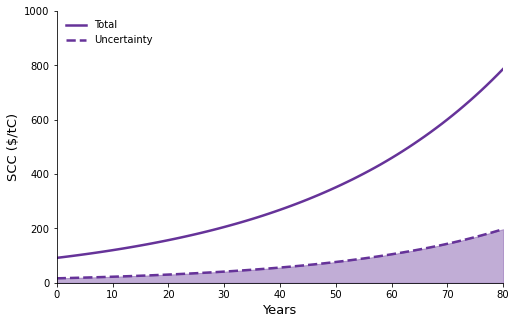

In [17]:
SCCt_all = η*(0.025)*Kt[:81]/((1.-η)*et) * 1000
SCCt_baseline = SCCt_all * ratio_t
SCCt_uncertainty = SCCt_all - SCCt_baseline

plt.figure(figsize=(8, 5))
plt.plot(SCCt_all, color='rebeccapurple', label='Total', linewidth=2.5)
plt.plot(SCCt_uncertainty, color='rebeccapurple', label='Uncertainty', linestyle='dashed', linewidth=2.5)
plt.fill_between(np.arange(0, 81, 1), np.zeros_like(SCCt_uncertainty), 
                 SCCt_uncertainty, color='rebeccapurple', alpha=.4)
plt.ylim(0, 1000)
plt.xlim(0, 80)
plt.xlabel('Years', fontsize=13)
plt.ylabel('SCC ($/tC)', fontsize=13)
plt.legend(frameon=False, loc='upper left')
plt.savefig('../plots/scc.pdf')

In [18]:
SCCt_all

array([ 91.68648963,  94.18585555,  96.75246565,  99.38826507,
       102.0976161 , 104.8805615 , 107.73405864, 110.66625682,
       113.67486913, 116.77123458, 119.95091891, 123.21497228,
       126.56871702, 130.00228493, 133.54230926, 137.17101325,
       140.89762291, 144.73005832, 148.68453713, 152.73293194,
       156.88501395, 161.14953735, 165.52336622, 170.0400497 ,
       174.67152538, 179.41159616, 184.29218576, 189.30777273,
       194.45693855, 199.75210834, 205.20308537, 210.79114521,
       216.50894415, 222.38255181, 228.43190488, 234.64029812,
       241.00444597, 247.56968327, 254.36254755, 261.28762011,
       268.41991287, 275.7047971 , 283.22652517, 290.94520996,
       298.85546617, 307.00094974, 315.39683319, 323.97117332,
       332.81433224, 341.86627091, 351.14329366, 360.68356083,
       370.47636141, 380.44690471, 390.81807159, 401.44060664,
       412.31239577, 423.4630966 , 434.91920412, 446.83569563,
       458.99432045, 471.51259824, 484.40368461, 497.61

In [19]:
SCCt_uncertainty

array([ 16.49618172,  17.00306436,  17.52522253,  18.06386783,
        18.61971152,  19.19277078,  19.78331814,  20.39193984,
        21.01999984,  21.66817183,  22.33715067,  23.02643399,
        23.7378221 ,  24.46951012,  25.2265962 ,  26.00654289,
        26.81046559,  27.64142942,  28.5012346 ,  29.38678403,
        30.29796979,  31.23942934,  32.20800231,  33.2137732 ,
        34.24827163,  35.31422312,  36.41460785,  37.55242224,
        38.72416768,  39.93609978,  41.18744694,  42.47763819,
        43.80322136,  45.17178756,  46.58660498,  48.0453934 ,
        49.54837115,  51.1038852 ,  52.72082921,  54.37571094,
        56.09013759,  57.84718929,  59.67053441,  61.54807927,
        63.48305579,  65.48474647,  67.55602256,  69.69140379,
        71.89856332,  74.18483345,  76.53867833,  78.97679334,
        81.5001174 ,  84.08053618,  86.7861422 ,  89.56689432,
        92.43033666,  95.38301214,  98.42564708, 101.60195656,
       104.85573905, 108.21208485, 111.67423665, 115.23

In [20]:
ratio_t

array([0.82008056, 0.81947327, 0.81886537, 0.81824949, 0.81762834,
       0.81700355, 0.81636895, 0.8157348 , 0.81508666, 0.81443913,
       0.81378091, 0.81311984, 0.81245111, 0.81177631, 0.8110966 ,
       0.81040788, 0.80971669, 0.8090139 , 0.8083107 , 0.80759366,
       0.80687786, 0.80614633, 0.80541719, 0.80467088, 0.80392756,
       0.80316644, 0.80240829, 0.80163296, 0.80085993, 0.8000717 ,
       0.79928447, 0.79848471, 0.79768401, 0.79687351, 0.79605911,
       0.7952381 , 0.79440889, 0.79357777, 0.79273352, 0.79189327,
       0.79103585, 0.79018432, 0.78931869, 0.78845474, 0.78757941,
       0.7866953 , 0.78580627, 0.78488394, 0.78396795, 0.78300043,
       0.78203007, 0.78103578, 0.78001264, 0.77899535, 0.77793723,
       0.77688631, 0.7758245 , 0.77475484, 0.77369211, 0.77261898,
       0.7715533 , 0.77050012, 0.76946039, 0.76842795, 0.76741944,
       0.76642112, 0.76542105, 0.76438804, 0.76336216, 0.76228154,
       0.76113769, 0.76000176, 0.75880058, 0.7575767 , 0.75636